In [6]:
# install requirements
#!pip install numpy pandas scikit-learn matplotlib seaborn

In [7]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath('../src'))

# Make an experimental design table
Here the settings for the experiments can be modified in the dictionary called run_settings. Refer to the paper for more details on of each of the parameters.

In [8]:
run_settings = {# level of entropy: min, medium and/or max
                "process_entropy":["min_entropy"], #"min_entropy","med_entropy","max_entropy"
                
                # number of traces/cases in the event-log
                "number_of_traces":[500],

                # number of activity types
                "statespace_size":[5], 

                # first or higher-order markov chain to represent the transitions
                "process_type":["memoryless"], 
                
                # order of HOMC - only specify this when using process with memory
                "process_memory":[1],
                
                # number of transitions - only used for medium entropy (should be higher than 2 and < statespace size)
                "med_ent_n_transitions":[1,2,3,4,5],
                                
                # lambda parameter of inter-arrival times
                "inter_arrival_time":[1],
                
                # lambda parameter of process noise
                "process_stability_scale":[0.1],
                
                # probability of agent being available
                "resource_availability_p":[0.5],

                # number of agents in the process
                "resource_availability_n":[3],

                # waiting time in full days, when no agent is available
                "resource_availability_m":[0.041],
                
                # variation between activity durations
                "activity_duration_lambda_range":[1],
                
                # business hours definition: when can cases be processed? ()
                "Deterministic_offset_W":["weekdays"],

                # time-unit for a full week: days = 7, hrs = 24*7, etc.
                "Deterministic_offset_u":[7],
                
                # training data format (See Verenich et al., 2019): 
                # True - use first event to predict total cycle-time. 
                # False - use Prefix-log format / each event to predict remaining cycle time.
                "first_state_model":[False],

                # offset for the timestamps used (years after 1970)
                "datetime_offset":[54],
                
                # number of repetitions of the experiments: duplicates the experiment table (2 times here)
                "num_replications":list(range(0, 5))
               }


# import the make_design_table function to generate a full factorial experimental design table
from SynBPS.design.DoE import make_design_table
df = make_design_table(run_settings)

# give each run its own seed value such that results are different across runs
df["seed_value"] = range(0,len(df))

# store the design table
df.to_csv("data/design_table.csv", index=False)

# inspect the resulting design table
df

,process_entropy,number_of_traces,statespace_size,process_type,process_memory,med_ent_n_transitions,inter_arrival_time,process_stability_scale,resource_availability_p,resource_availability_n,...,activity_duration_lambda_range,Deterministic_offset_W,Deterministic_offset_u,first_state_model,datetime_offset,num_replications,RUN,Done,Failure,seed_value
0,min_entropy,500.0,5,memoryless,1.0,1.0,1.0,0.1,0.5,3.0,...,1.0,weekdays,7.0,False,54.0,0.0,1,0,0,0
1,min_entropy,500.0,5,memoryless,1.0,2.0,1.0,0.1,0.5,3.0,...,1.0,weekdays,7.0,False,54.0,0.0,2,0,0,1
2,min_entropy,500.0,5,memoryless,1.0,3.0,1.0,0.1,0.5,3.0,...,1.0,weekdays,7.0,False,54.0,0.0,3,0,0,2
3,min_entropy,500.0,5,memoryless,1.0,4.0,1.0,0.1,0.5,3.0,...,1.0,weekdays,7.0,False,54.0,0.0,4,0,0,3
4,min_entropy,500.0,5,memoryless,1.0,5.0,1.0,0.1,0.5,3.0,...,1.0,weekdays,7.0,False,54.0,0.0,5,0,0,4
5,min_entropy,500.0,5,memoryless,1.0,1.0,1.0,0.1,0.5,3.0,...,1.0,weekdays,7.0,False,54.0,1.0,6,0,0,5
6,min_entropy,500.0,5,memoryless,1.0,2.0,1.0,0.1,0.5,3.0,...,1.0,weekdays,7.0,False,54.0,1.0,7,0,0,6
7,min_entropy,500.0,5,memoryless,1.0,3.0,1.0,0.1,0.5,3.0,...,1.0,weekdays,7.0,False,54.0,1.0,8,0,0,7
8,min_entropy,500.0,5,memoryless,1.0,4.0,1.0,0.1,0.5,3.0,...,1.0,weekdays,7.0,False,54.0,1.0,9,0,0,8
9,min_entropy,500.0,5,memoryless,1.0,5.0,1.0,0.1,0.5,3.0,...,1.0,weekdays,7.0,False,54.0,1.0,10,0,0,9


# Specify Train() and Test() functions
Before running the experiments, you need to define model training and evaluation functions.

In this example we train a first state model, which is a model using only the first observed event (state) to predict to total cycle-time. The default data preparation will result in a prefix-log, which can be used to predict remaining cycle-time from every observed event in the trace.

Input for the **training_function** is a dictionary named **input_data**, which contain the following:
- x_train
- x_test
- y_train
- y_test

Output is an **inference table** containing predictions and actual target values for the test data. This table is used for analysis of the results. The **eval_function** also uses this table to calculate aggregated metrics.

In [9]:
def training_function(input_data):
    #print("training")
    
    """
    Example model: Lasso regression
    This is just an example of how to define your model in this framework.
    Using this model on this data format is not advised as we break i.i.d. assumptions.
    """

    #retrieve model class from sklearn
    from sklearn import linear_model


    # Lasso model
    reg = linear_model.Lasso(alpha=0.1)
    
    # OLS
    #reg = linear_model.LinearRegression()

    #reshape training data for this type of model 
    #(from: N x t x k, to: N x (t x k))
    #num_obs = input_data["x_train"].shape[0]
    from numpy import prod
    flattened_dim = prod(input_data["x_train"].shape[1:])

    #train the regression model
    reg.fit(input_data["x_train"].reshape((input_data["x_train"].shape[0], flattened_dim)), input_data["y_train"])

    #predict on the test data
    y_pred = reg.predict(input_data["x_test"].reshape((input_data["x_test"].shape[0], flattened_dim)))

    #get the inference table (used for analysis of the final results)
    inference = input_data["Inference_test"]
    
    #add predictions to the inference table
    inference["y_pred"] = y_pred
    return inference

#from sklearn.metrics 

def eval_function(inference):
    #print("evaluation")
    """
    Example evaluation: Aggregated scores
    The inference table also enable the ability to make trace or prefix-level evaluations using its id variables
    """
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

    y = inference["y"]
    y_pred = inference["y_pred"]

    MSE = mean_squared_error(y, y_pred)
    MAE = mean_absolute_error(y, y_pred)
    R2 = r2_score(y, y_pred)
    EVAR = explained_variance_score(y, y_pred)

    # the resulting metrics should be stored in a dictionary and be scalars only
    # adding prefixes to column name (key) is suggested when logging many metrics
    metrics = {"TEST_MSE":MSE,
              "TEST_MAE":MAE,
              "TEST_R2":R2,
              "TEST_EVAR":EVAR}
    #print(metrics)
    return metrics

# Perform the experiments
Now we perform the experiments using the defined training and evaluation functions.

In [10]:
from SynBPS.simulation.simulation_pipeline import run_experiments

# function to run a set of experiments
results = run_experiments(training_function, 
                          eval_function, 
                          store_eventlogs=False, #set to True if all simulated event-logs should be stored (highly recommended for in-depth analysis)
                          output_dir="data/",
                          out_file="results.csv", 
                          design_table="design_table.csv")

100%|██████████| 25/25 [01:58<00:00,  4.74s/it]


# Analysis
Firstly we load the results table which contain aggregated metrics based on the individual runs.

In [11]:
import pandas as pd
df = pd.read_csv("data/results.csv")
df

,process_entropy,number_of_traces,statespace_size,process_type,process_memory,med_ent_n_transitions,inter_arrival_time,process_stability_scale,resource_availability_p,resource_availability_n,...,num_events,num_variants,avg_tracelen,min_tracelen,max_tracelen,RESULT_num_events,TEST_MSE,TEST_MAE,TEST_R2,TEST_EVAR
0,min_entropy,500.0,5,memoryless,1.0,1.0,1.0,0.1,0.5,3.0,...,2500,1,5.0,5,5,2500,1.555059e+10,91487.733378,0.303215,0.303218
1,min_entropy,500.0,5,memoryless,1.0,2.0,1.0,0.1,0.5,3.0,...,2500,1,5.0,5,5,2500,9.699602e+09,73999.510254,0.554444,0.556110
2,min_entropy,500.0,5,memoryless,1.0,3.0,1.0,0.1,0.5,3.0,...,2500,1,5.0,5,5,2500,1.151795e+10,82362.639947,0.568657,0.570178
3,min_entropy,500.0,5,memoryless,1.0,4.0,1.0,0.1,0.5,3.0,...,2500,1,5.0,5,5,2500,2.505170e+10,125104.666241,0.392854,0.394984
4,min_entropy,500.0,5,memoryless,1.0,5.0,1.0,0.1,0.5,3.0,...,2500,1,5.0,5,5,2500,7.537214e+09,64835.260934,0.597784,0.598346
5,min_entropy,500.0,5,memoryless,1.0,1.0,1.0,0.1,0.5,3.0,...,2500,1,5.0,5,5,2500,1.689102e+10,99232.269692,0.447400,0.447450
6,min_entropy,500.0,5,memoryless,1.0,2.0,1.0,0.1,0.5,3.0,...,2500,1,5.0,5,5,2500,7.005407e+09,61039.707894,0.533214,0.538987
7,min_entropy,500.0,5,memoryless,1.0,3.0,1.0,0.1,0.5,3.0,...,2500,1,5.0,5,5,2500,9.161286e+09,72049.070780,0.545166,0.551659
8,min_entropy,500.0,5,memoryless,1.0,4.0,1.0,0.1,0.5,3.0,...,2500,1,5.0,5,5,2500,1.723025e+10,101686.571804,0.368875,0.371029
9,min_entropy,500.0,5,memoryless,1.0,5.0,1.0,0.1,0.5,3.0,...,2500,1,5.0,5,5,2500,1.081261e+10,79721.955874,0.466411,0.468754


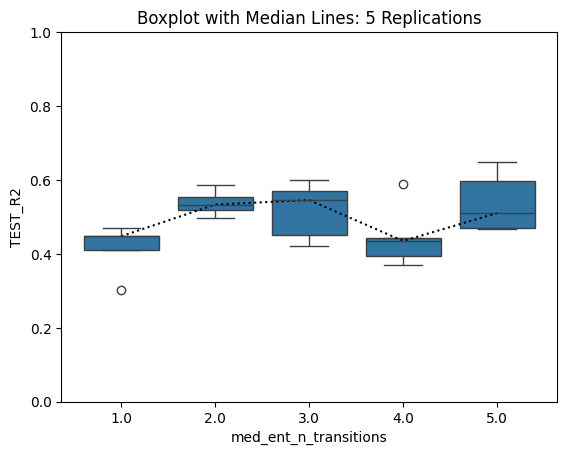

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create boxplot
sns.boxplot(data=df, x='med_ent_n_transitions', y='TEST_R2')

# Calculate medians and plot lines
medians = df.groupby(['med_ent_n_transitions'])['TEST_R2'].median().values
n = len(medians)
sns.lineplot(x=range(n), y=medians, sort=False, linestyle='dotted', color="black")

# Set title and y-axis range
plt.title('Boxplot with Median Lines: 5 Replications')
plt.ylim(0, 1)

plt.show()
